In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 700 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 55.3MB/s]
100% 2.29G/2.29G [00:20<00:00, 123MB/s] 


In [6]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd

In [8]:
labels= ['PNEUMONIA' , 'NORMAL']
img_size = 200
def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir , label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [9]:
train = get_data('/content/chest_xray/train')
test = get_data('/content/chest_xray/test')
val = get_data('/content/chest_xray/val')

<ipython-input-8-33625bc21cb1>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [10]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)


for feature, label in test:
    x_test.append(feature)
    y_test.append(label)


for feature, label in val:
    x_val.append(feature)
    y_val.append(label)




In [11]:
positives=[]
negatives=[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else:
        negatives.append(x_train[i])

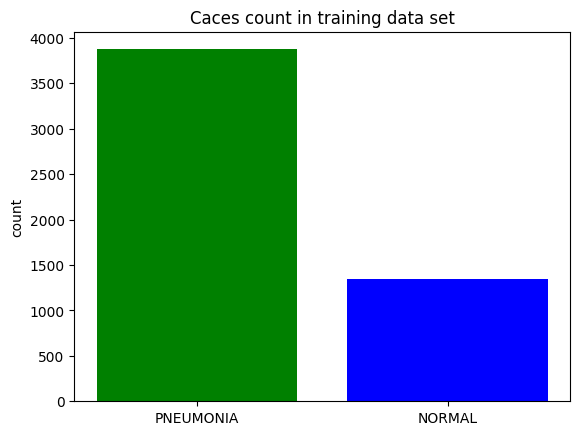

In [12]:
plt.bar(labels, [len(negatives), len(positives)], color=["green", "blue"])
plt.title("Caces count in training data set")
plt.ylabel("count")
plt.show()

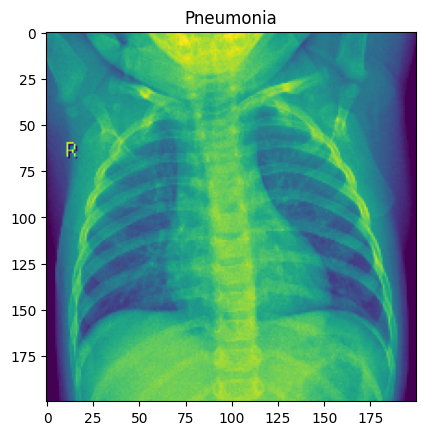

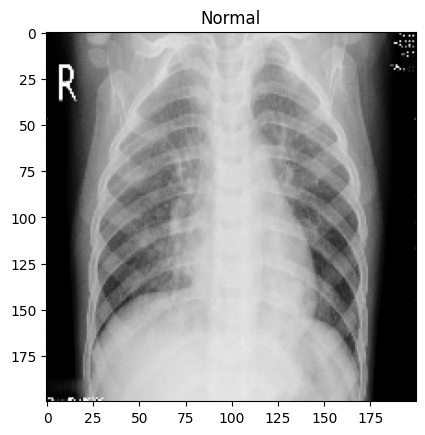

In [13]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4], cmap="gray")
plt.title("Normal")
plt.show()


In [14]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

In [15]:
x_train  = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test  = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val  = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [16]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [17]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train)

In [18]:
model=Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu' , input_shape = (200,200,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))

model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu' ))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))

model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))

model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))

model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 100, 100, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 64)     2

In [19]:
model.compile(optimizer = "rmsprop", loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [20]:
learning_rate_reduction =ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [21]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32),
                   epochs = 15,
                   validation_data = datagen.flow(x_val, y_val),
                   callbacks = learning_rate_reduction)

Epoch 1/15
163/163 [==============================] - 39s 138ms/step - loss: 0.5675 - accuracy: 0.8441 - val_loss: 40.6371 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 22s 135ms/step - loss: 0.2802 - accuracy: 0.8911 - val_loss: 20.7933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9166
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 21s 129ms/step - loss: 0.2343 - accuracy: 0.9166 - val_loss: 5.5428 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 22s 134ms/step - loss: 0.1560 - accuracy: 0.9429 - val_loss: 6.4151 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/15
163/163 [==============================] - 22s 136ms/step - loss: 0.1431 - accuracy: 0.9502 - val_loss: 0.5857 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 6/15
163/163 [===================

In [22]:
print("Loss of the model is - ", model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test,y_test)[1]*100,"%")

20/20 [==============================] - 0s 14ms/step - loss: 0.2749 - accuracy: 0.9038
Loss of the model is -  0.27494049072265625
20/20 [==============================] - 0s 15ms/step - loss: 0.2749 - accuracy: 0.9038
Accuracy of the model is -  90.38461446762085 %


Text(0, 0.5, 'Loss')

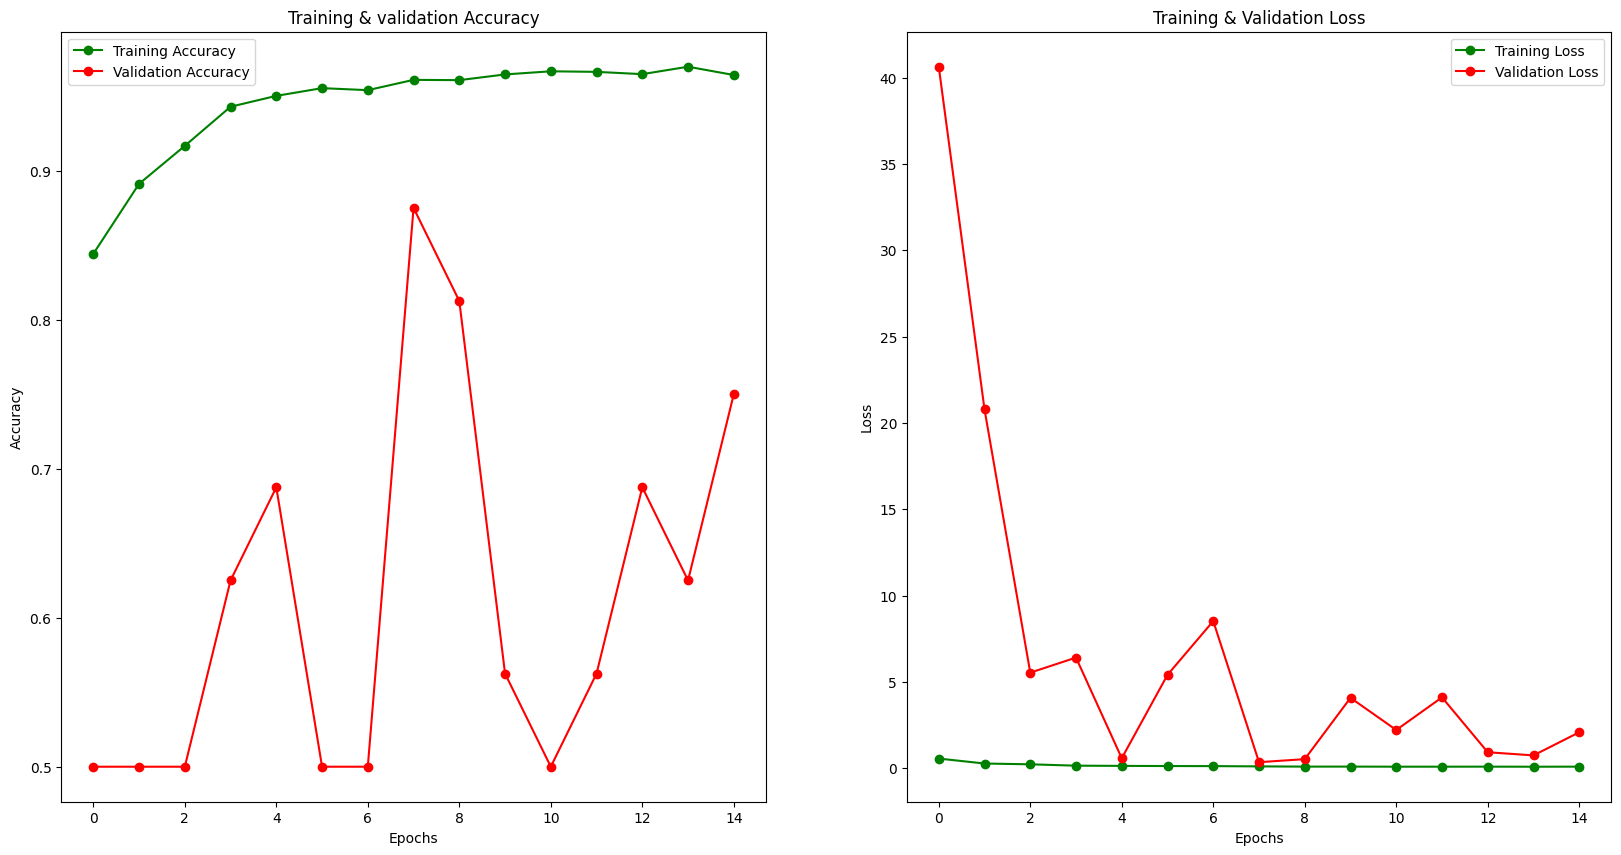

In [23]:
epochs=list(range(15))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = "Training Accuracy")
ax[0].plot(epochs , val_acc , 'ro-' , label = "Validation Accuracy")
ax[0].set_title('Training & validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = "Training Loss")
ax[1].plot(epochs , val_loss , 'r-o' , label = "Validation Loss")
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")



In [24]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
  predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 0s 12ms/step


In [25]:
print(classification_report(y_test,
                            predictions,
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.93      0.92       390
   Normal (Class 1)       0.88      0.87      0.87       234

           accuracy                           0.90       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.90      0.90      0.90       624



In [26]:
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm , index = ['0','1'])
cm

,0,1
0,361,29
1,31,203


In [27]:
def PneumoniaPrediction(img):
  img = np.array(img)/255
  img = img.reshape(-1, 200, 200, 1)
  isPneumonic = model.predict(img)[0]
  imgClass = "Normal" if isPneumonic<0.5 else "Pneumonic"
  return imgClass

In [28]:
pr = model.predict(x_test)
for i in range(len(pr)):
  if pr[i]>0.5:
    pr[i]=1
  else:
    pr[i]=0


20/20 [==============================] - 0s 12ms/step


In [29]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [30]:
import gradio

In [31]:
img = gradio.inputs.Image(shape=(200,200))
label = gradio.outputs.Label(num_top_classes=1)

<ipython-input-31-1ab1498917ff>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  img = gradio.inputs.Image(shape=(200,200))
<ipython-input-31-1ab1498917ff>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  img = gradio.inputs.Image(shape=(200,200))
<ipython-input-31-1ab1498917ff>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gradio.outputs.Label(num_top_classes=1)
<ipython-input-31-1ab1498917ff>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gradio.outputs.Label(num_top_classes=1)


In [ ]:
interface = gradio.Interface(fn = PneumoniaPrediction,
                             title = "Pneumonia Detaction using Chest X-Ray",
                             inputs = img,
                             outputs = label,
                             interpretation = "default"
                             )
interface.launch(debug=True , share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://375ee79ea7c21d0bab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 21ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://375ee79ea7c21d0bab.gradio.live


In [ ]:
y_test.shape